# BDML Final Group Project: Kobe Bryant Shot Selection

###### By Zixiao Kang (conradkang@jhu.edu), Yanchen Lin (photosharelin@gmail.com), Kefan Gao (Gaokefan967@gmail.com), Limou Xie (xielimoupeter@gmail.com)

## 0. Preparation

In [1]:
import warnings
warnings.filterwarnings('ignore') # kill the warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn import mixture
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

import re
import time
import itertools
import operator

In [2]:
pd.set_option('display.max_columns', None) # show all columns
%matplotlib inline

## 1. Data Understanding

In [3]:
data_raw = pd.read_csv('data.csv')
data_pl = data_raw[data_raw['shot_made_flag'].notnull()].reset_index() # for plotting
data = data_raw.copy() # for cleaning
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
data.set_index('shot_id', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 1 to 30697
Data columns (total 24 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [5]:
data.drop(['shot_made_flag'], axis = 1).isnull().values.any() # see if there exists missing values

False

In [6]:
data.describe(include=['number'])

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09


In [7]:
data.describe(include=['object'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


In [8]:
# Transform some features to be category type
data["period"] = data["period"].astype('category')
data["playoffs"] = data["playoffs"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["shot_zone_area"] = data["shot_zone_area"].astype('category')
data["shot_zone_basic"] = data["shot_zone_basic"].astype('category')
data["shot_zone_range"] = data["shot_zone_range"].astype('category')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30697 entries, 1 to 30697
Data columns (total 24 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null category
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null category
playoffs              30697 non-null category
season                30697 non-null category
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null category
shot_type             30697 non-null category
shot_zone_area        30697 non-null category
shot_zone_basic       30697 non-null category
shot_zone_range       30697 non-null category
team_id               30697 non-null int64

In [10]:
data.describe(include=['number'])

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,seconds_remaining,shot_distance,team_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,3.069700e+04
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,28.365085,13.437437,1.610613e+09
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,17.478949,9.374189,0.000000e+00
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,0.000000,0.000000,1.610613e+09
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,13.000000,5.000000,1.610613e+09
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,28.000000,15.000000,1.610613e+09
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,43.000000,21.000000,1.610613e+09
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,59.000000,79.000000,1.610613e+09


In [11]:
data.describe(include=['object', 'category'])

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,25697.0,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,7,2,20,2.0,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,3,0,2005-06,0.0,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,8296,26198,2318,14232.0,24271,13455,12625,9398,30697,50,1020,1978


In [12]:
set(data.action_type.tolist()) # let's see what's inside action_type

{'Alley Oop Dunk Shot',
 'Alley Oop Layup shot',
 'Cutting Finger Roll Layup Shot',
 'Cutting Layup Shot',
 'Driving Bank shot',
 'Driving Dunk Shot',
 'Driving Finger Roll Layup Shot',
 'Driving Finger Roll Shot',
 'Driving Floating Bank Jump Shot',
 'Driving Floating Jump Shot',
 'Driving Hook Shot',
 'Driving Jump shot',
 'Driving Layup Shot',
 'Driving Reverse Layup Shot',
 'Driving Slam Dunk Shot',
 'Dunk Shot',
 'Fadeaway Bank shot',
 'Fadeaway Jump Shot',
 'Finger Roll Layup Shot',
 'Finger Roll Shot',
 'Floating Jump shot',
 'Follow Up Dunk Shot',
 'Hook Bank Shot',
 'Hook Shot',
 'Jump Bank Shot',
 'Jump Hook Shot',
 'Jump Shot',
 'Layup Shot',
 'Pullup Bank shot',
 'Pullup Jump shot',
 'Putback Dunk Shot',
 'Putback Layup Shot',
 'Putback Slam Dunk Shot',
 'Reverse Dunk Shot',
 'Reverse Layup Shot',
 'Reverse Slam Dunk Shot',
 'Running Bank shot',
 'Running Dunk Shot',
 'Running Finger Roll Layup Shot',
 'Running Finger Roll Shot',
 'Running Hook Shot',
 'Running Jump Shot',


In [13]:
data.action_type.value_counts() # for later filtering

Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot              

## 2. Gorgeous Plots

### 2.1 Time VS. Attempts & FG%

In [14]:
# Adding features for plots
data_pl['game_date_DT'] = pd.to_datetime(data_pl['game_date'])
data_pl['dayOfWeek'] = data_pl['game_date_DT'].dt.dayofweek
data_pl['dayOfYear'] = data_pl['game_date_DT'].dt.dayofyear

data_pl['secondsFromPeriodEnd'] = 60 * data_pl['minutes_remaining'] + data_pl['seconds_remaining']
data_pl['secondsFromPeriodStart'] = 60 * 12 - data_pl['secondsFromPeriodEnd']
data_pl['secondsFromGameStart'] = (data_pl['period'] <= 4).astype(int)*(data_pl['period'] - 1)*12*60 + (data_pl['period'] > 4).astype(int)*((data_pl['period'] - 4)*5*60 + 3*12*60) + data_pl['secondsFromPeriodStart']

data_pl.loc[:10,['period','minutes_remaining','seconds_remaining','secondsFromGameStart']]

,period,minutes_remaining,seconds_remaining,secondsFromGameStart
0,1,10,22,98
1,1,7,45,255
2,1,6,52,308
3,2,6,19,1061
4,3,9,32,1588
5,3,8,52,1628
6,3,6,12,1788
7,3,3,36,1944
8,3,1,56,2044
9,1,11,0,60


Text(0.5, 0, 'time [seconds from start of game]')

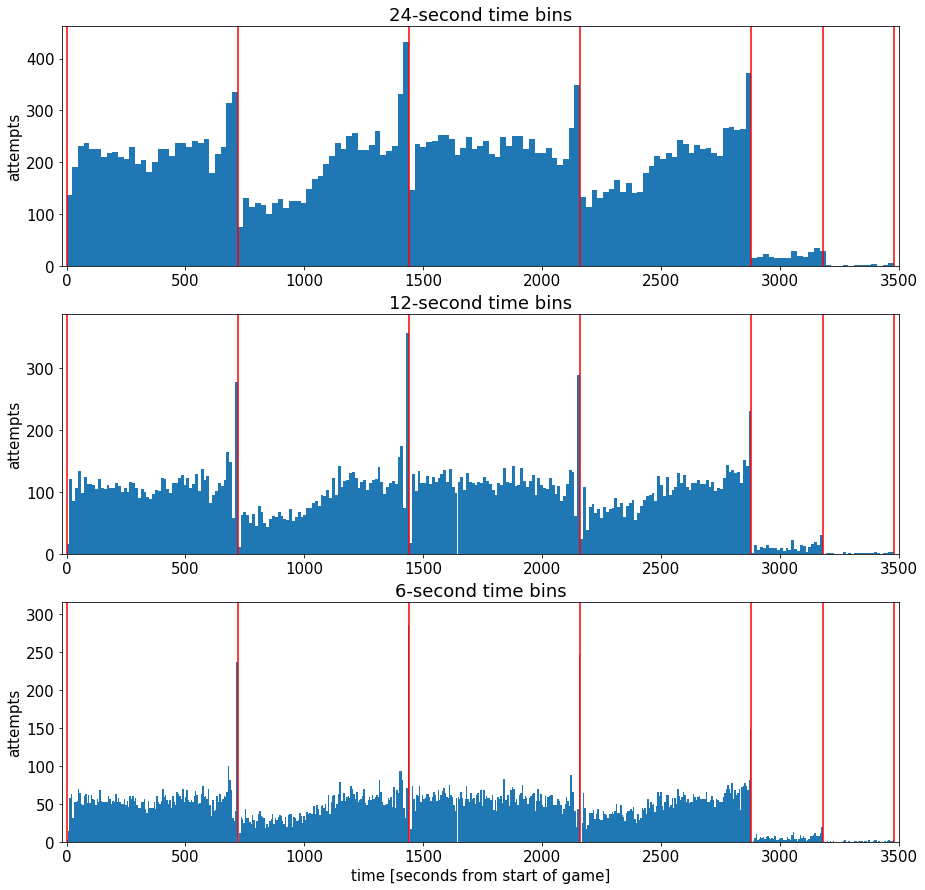

In [15]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['font.size'] = 15

binsSizes = [24,12,6]

plt.figure()

for k, binSize in enumerate(binsSizes):
    timeBins = np.arange(0, 60*(4*12+3*5), binSize) + 0.01
    attempts, b = np.histogram(data_pl['secondsFromGameStart'], bins = timeBins)     
    
    maxHeight = max(attempts) + 30
    barWidth = 0.999 * (timeBins[1] - timeBins[0])
    plt.subplot(len(binsSizes), 1, k + 1)
    plt.bar(timeBins[:-1], attempts, align='edge', width=barWidth)
    plt.title(str(binSize) + '-second time bins')
    plt.vlines(x = [0, 12*60, 2*12*60, 3*12*60, 4*12*60, 4*12*60 + 5*60, 4*12*60 + 2*5*60, 4*12*60 + 3*5*60], ymin = 0, ymax = maxHeight, colors = 'r')
    plt.xlim((-20,3500))
    plt.ylim((0, maxHeight))
    plt.ylabel('attempts')

plt.xlabel('time [seconds from start of game]')

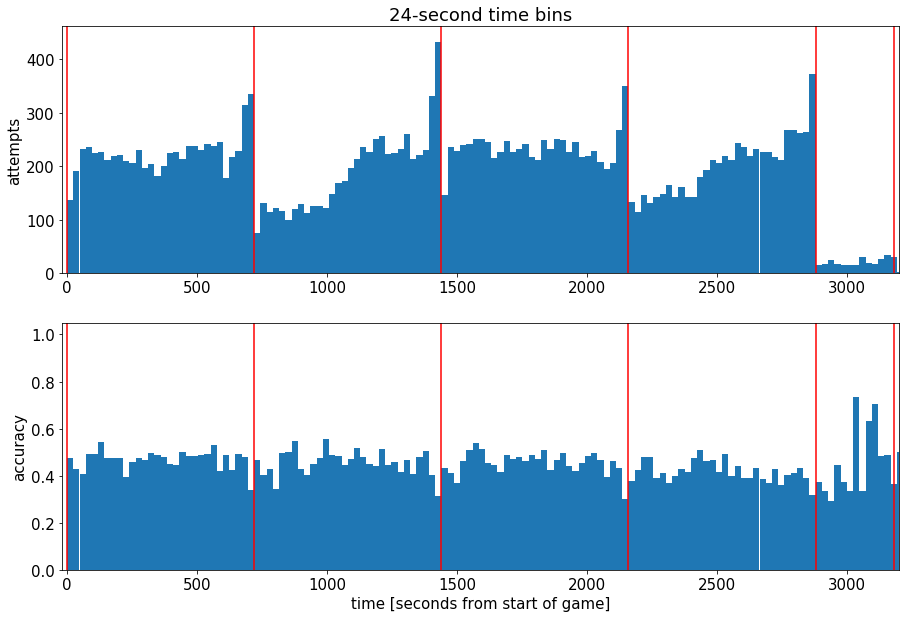

In [16]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 15

binSize = 24
timeBins = np.arange(0,60*(4*12+3*5), binSize) + 0.01

attempts, b = np.histogram(data_pl['secondsFromGameStart'], bins = timeBins)     
madeattempts, b = np.histogram(data_pl.loc[data_pl['shot_made_flag'] == 1, 'secondsFromGameStart'], bins = timeBins)     

attempts[attempts < 1] = 1
accuracy = madeattempts.astype(float)/attempts
#accuracy[attempts < 50] = 0 # ruin the overtime plots

maxHeight = max(attempts) + 30
barWidth = 0.999*(timeBins[1]-timeBins[0])

plt.figure()

plt.subplot(2,1,1)
plt.bar(timeBins[:-1], attempts, align='edge', width=barWidth) 
plt.xlim((-20, 3200))
plt.ylim((0, maxHeight))
plt.ylabel('attempts')
plt.title(str(binSize) + '-second time bins')
plt.vlines(x=[0, 12*60, 2*12*60, 3*12*60, 4*12*60, 4*12*60+5*60, 4*12*60+2*5*60, 4*12*60+3*5*60], ymin=0, ymax=maxHeight, colors='r')

plt.subplot(2,1,2)
plt.bar(timeBins[:-1], accuracy, align='edge', width=barWidth)
plt.xlim((-20, 3200))
plt.ylim((0, 1.05))
plt.ylabel('accuracy')
plt.xlabel('time [seconds from start of game]')
plt.vlines(x=[0, 12*60, 2*12*60, 3*12*60, 4*12*60, 4*12*60+5*60, 4*12*60+2*5*60, 4*12*60+3*5*60], ymin=0.0,ymax=1.05, colors='r')

### 2.2 Clustering Plots

In [17]:
# Clustering the shot attempts using GMM on the locations
numGaussians = 13

gaussianMixtureModel = mixture.GaussianMixture(n_components = numGaussians, covariance_type = 'full', 
                                               init_params = 'kmeans', n_init = 50, 
                                               verbose = False, random_state = 5) # seeds make different results

gaussianMixtureModel.fit(data_pl.loc[:,['loc_x','loc_y']])

# Adding the feature
data_pl['shotLocationCluster'] = gaussianMixtureModel.predict(data_pl.loc[:,['loc_x','loc_y']])

In [18]:
# Functions credit to Michael Krueger: Making the arena

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages):
    
    fig, h = plt.subplots();
    for i, (mean, covarianceMatrix) in enumerate(zip(gaussianMixtureModel.means_, gaussianMixtureModel.covariances_)):
        # get the eigen vectors and eigen values of the covariance matrix
        v, w = np.linalg.eigh(covarianceMatrix)
        v = 2.5*np.sqrt(v) # go to units of standard deviation instead of variance
        
        # calculate the ellipse angle and two axis length and draw it
        u = w[0] / np.linalg.norm(w[0])    
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        currEllipse = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=ellipseColors[i])
        currEllipse.set_alpha(0.5)
        h.add_artist(currEllipse)
        h.text(mean[0]+7, mean[1]-1, ellipseTextMessages[i], fontsize=13, color='blue')

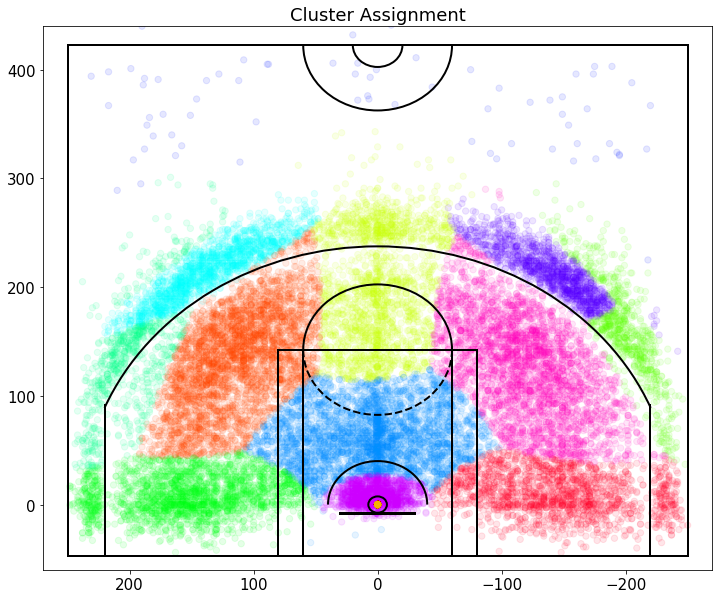

In [19]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 15

plt.figure()
draw_court(outer_lines = True)
plt.ylim(-60,440)
plt.xlim(270,-270)
plt.title('Cluster Assignment')

plt.scatter(x=data_pl['loc_x'], y=data_pl['loc_y'], c=data_pl['shotLocationCluster'], s=40, cmap='gist_rainbow', alpha=0.1)

Text(0.5, 1.0, 'Shot Attempts')

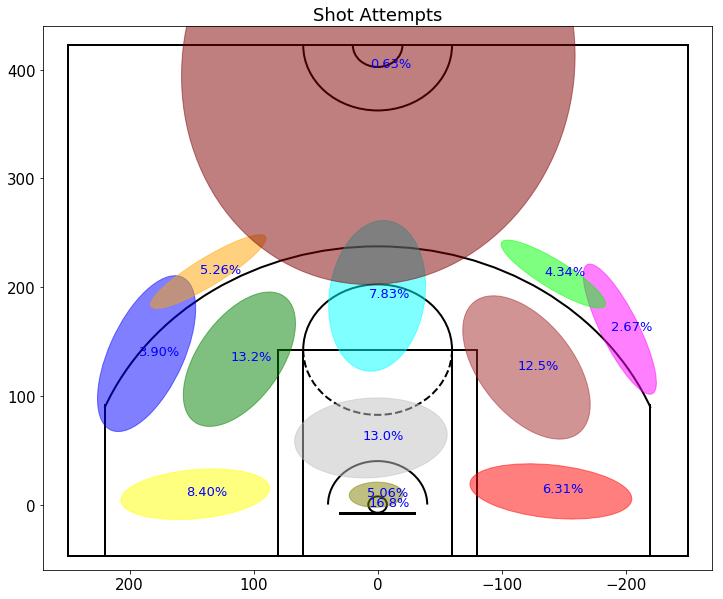

In [20]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 15

ellipseTextMessages = [str(100*gaussianMixtureModel.weights_[x])[:4] + '%' for x in range(numGaussians)]
ellipseColors = ['red','green','purple','cyan','magenta','yellow','blue','orange','silver','maroon','lime','olive','brown','darkblue']
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)

draw_court(outer_lines=True)
plt.ylim(-60,440)
plt.xlim(270,-270)
plt.title('Shot Attempts')

Text(0.5, 1.0, 'Shot Accuracy')

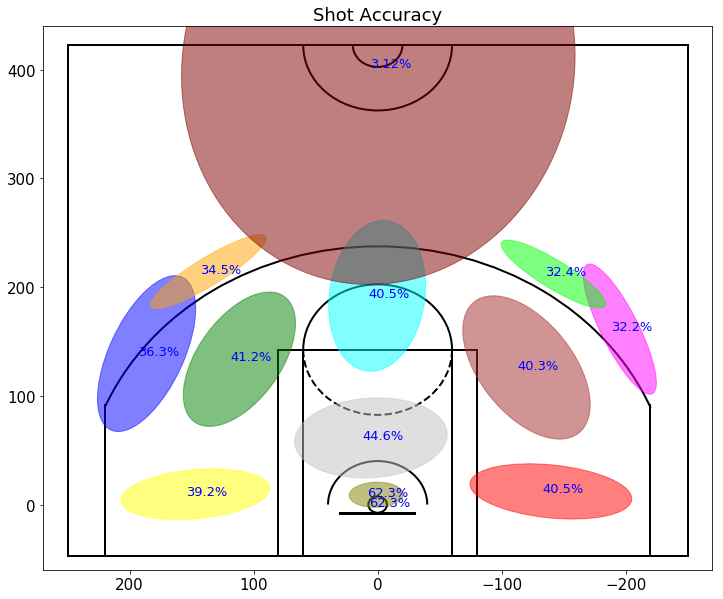

In [21]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 15

variableCategories = data_pl['shotLocationCluster'].value_counts().index.tolist()

clusterAccuracy = {}

for category in variableCategories:
    shotsAttempted = np.array(data_pl['shotLocationCluster'] == category).sum()
    shotsMade = np.array(data_pl.loc[data_pl['shotLocationCluster'] == category, 'shot_made_flag'] == 1).sum()
    clusterAccuracy[category] = float(shotsMade)/shotsAttempted

ellipseTextMessages = [str(100*clusterAccuracy[x])[:4] + '%' for x in range(numGaussians)]
Draw2DGaussians(gaussianMixtureModel, ellipseColors, ellipseTextMessages)

draw_court(outer_lines = True)
plt.ylim(-60,440)
plt.xlim(270,-270)
plt.title('Shot Accuracy')

## 3. Exploratory Data Analysis

### 3.1 EDA for the Response Variable (shot_made_flag)

In [22]:
# set background as paper...
sns.set_context("paper", rc={"font.size":10,"axes.titlesize":18,"axes.labelsize":15})

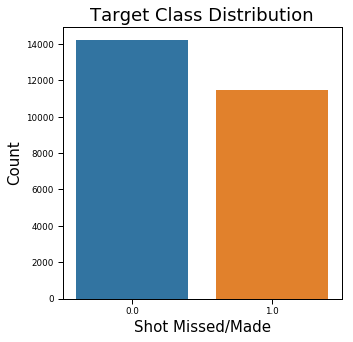

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x = 'shot_made_flag', data = data, ax = ax);
ax.set_title('Target Class Distribution')
ax.set(xlabel = 'Shot Missed/Made', ylabel = 'Count')
plt.show()

### 3.2 EDA for Continous Variables (ignoring all the ids)

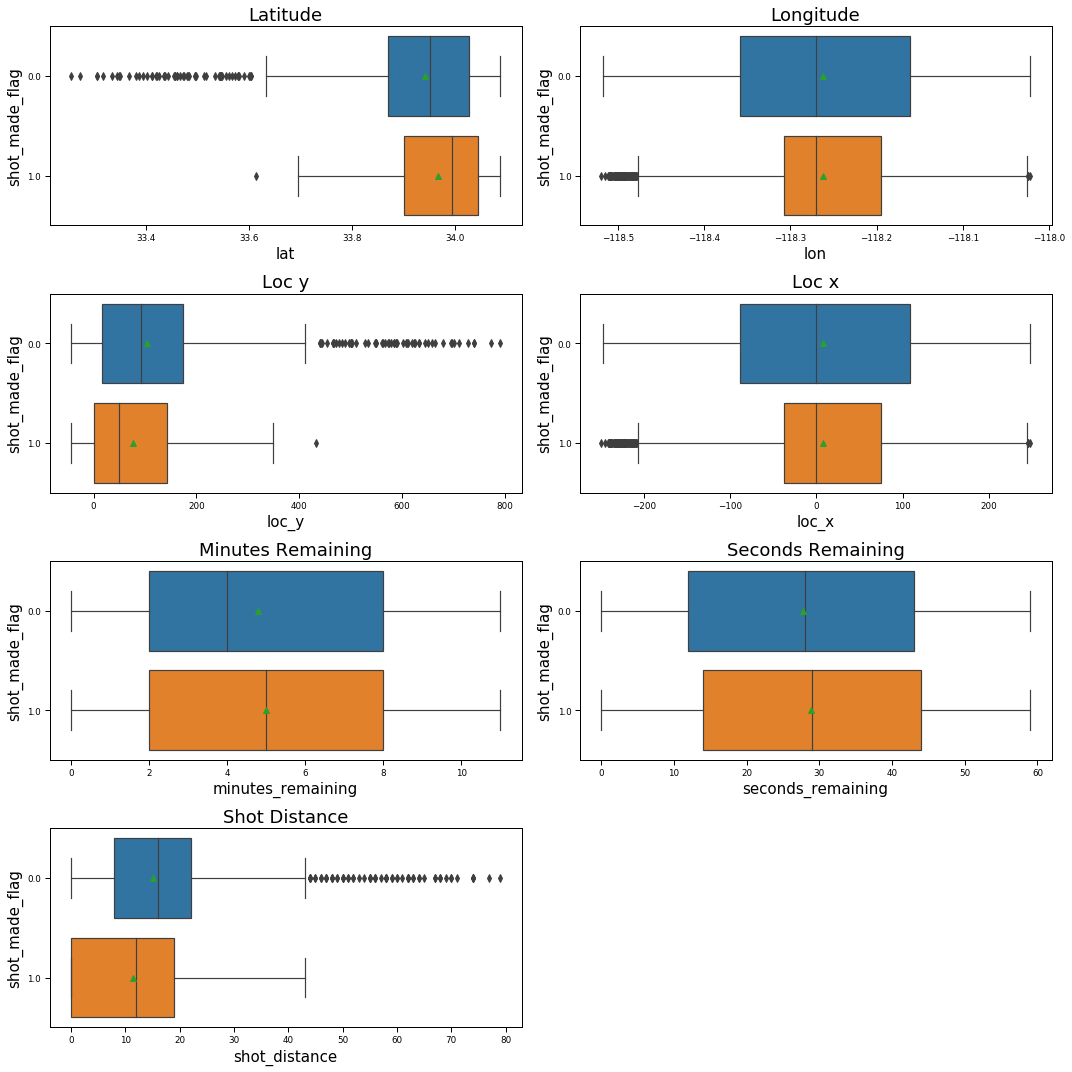

In [24]:
f, axarr = plt.subplots(4, 2, figsize=(15, 15))

sns.boxplot(x='lat', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0,0])
sns.boxplot(x='lon', y='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1])
sns.boxplot(x='loc_y', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 0])
sns.boxplot(x='loc_x', y='shot_made_flag', data=data, showmeans=True, ax=axarr[1, 1])
sns.boxplot(x='minutes_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 0])
sns.boxplot(x='seconds_remaining', y='shot_made_flag', showmeans=True, data=data, ax=axarr[2, 1])
sns.boxplot(x='shot_distance', y='shot_made_flag', data=data, showmeans=True, ax=axarr[3, 0])

axarr[0, 0].set_title('Latitude')
axarr[0, 1].set_title('Longitude')
axarr[1, 0].set_title('Loc y')
axarr[1, 1].set_title('Loc x')
axarr[2, 0].set_title('Minutes Remaining')
axarr[2, 1].set_title('Seconds Remaining')
axarr[3, 0].set_title('Shot Distance')

plt.tight_layout()
axarr[3, 1].set_axis_off() # remove the extra plot
plt.show()

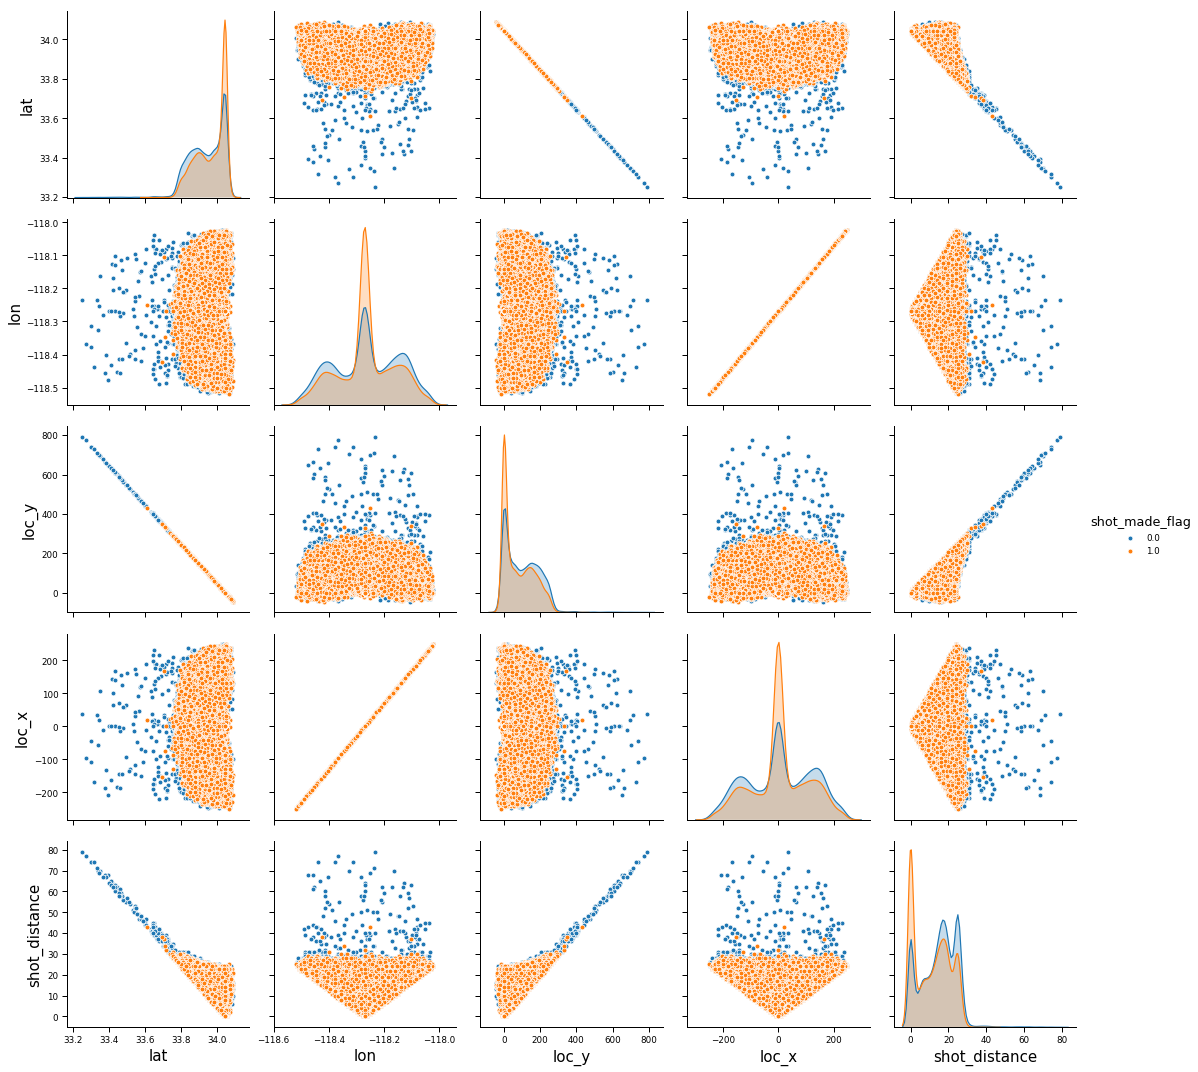

In [25]:
sns.pairplot(data, vars=['lat', 'lon', 'loc_y', 'loc_x', 'shot_distance'], hue='shot_made_flag', height = 3)
plt.show()

### 3.3 EDA for Categorical Variables

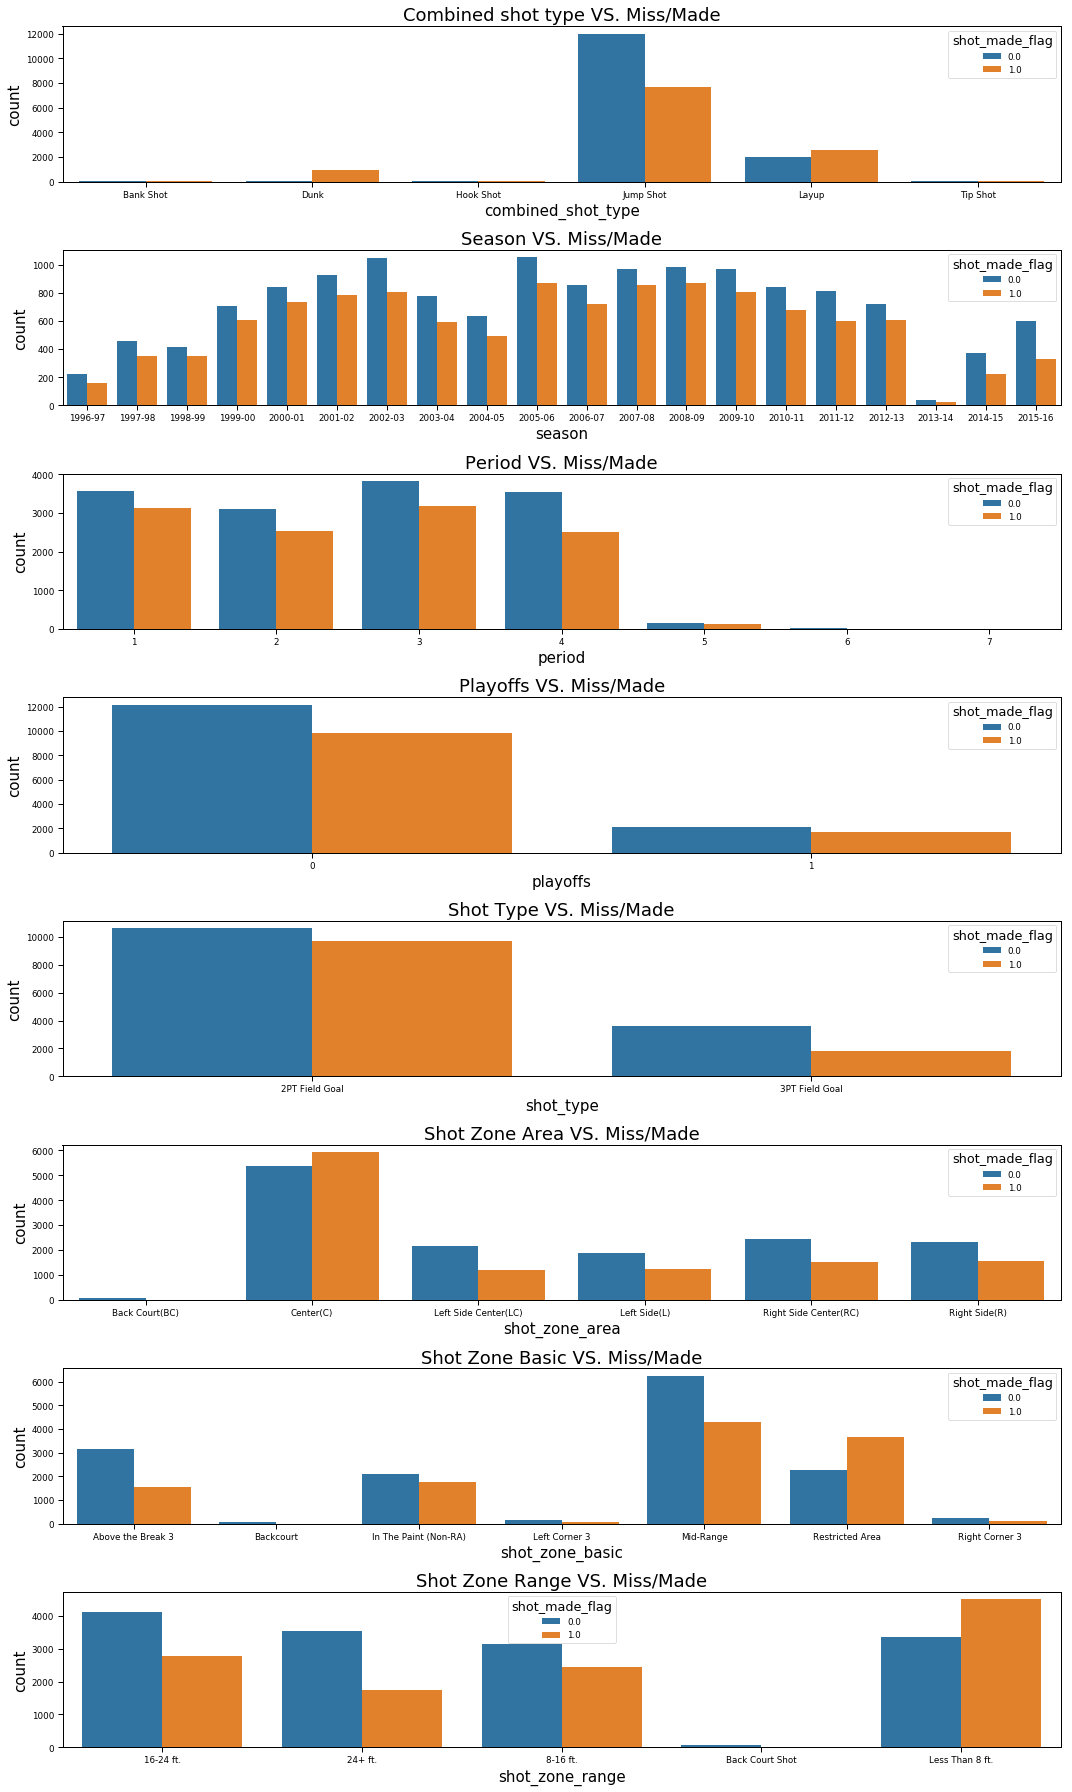

In [26]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axarr[7])

axarr[0].set_title('Combined shot type VS. Miss/Made')
axarr[1].set_title('Season VS. Miss/Made')
axarr[2].set_title('Period VS. Miss/Made')
axarr[3].set_title('Playoffs VS. Miss/Made')
axarr[4].set_title('Shot Type VS. Miss/Made')
axarr[5].set_title('Shot Zone Area VS. Miss/Made')
axarr[6].set_title('Shot Zone Basic VS. Miss/Made')
axarr[7].set_title('Shot Zone Range VS. Miss/Made')

plt.tight_layout()
plt.show()

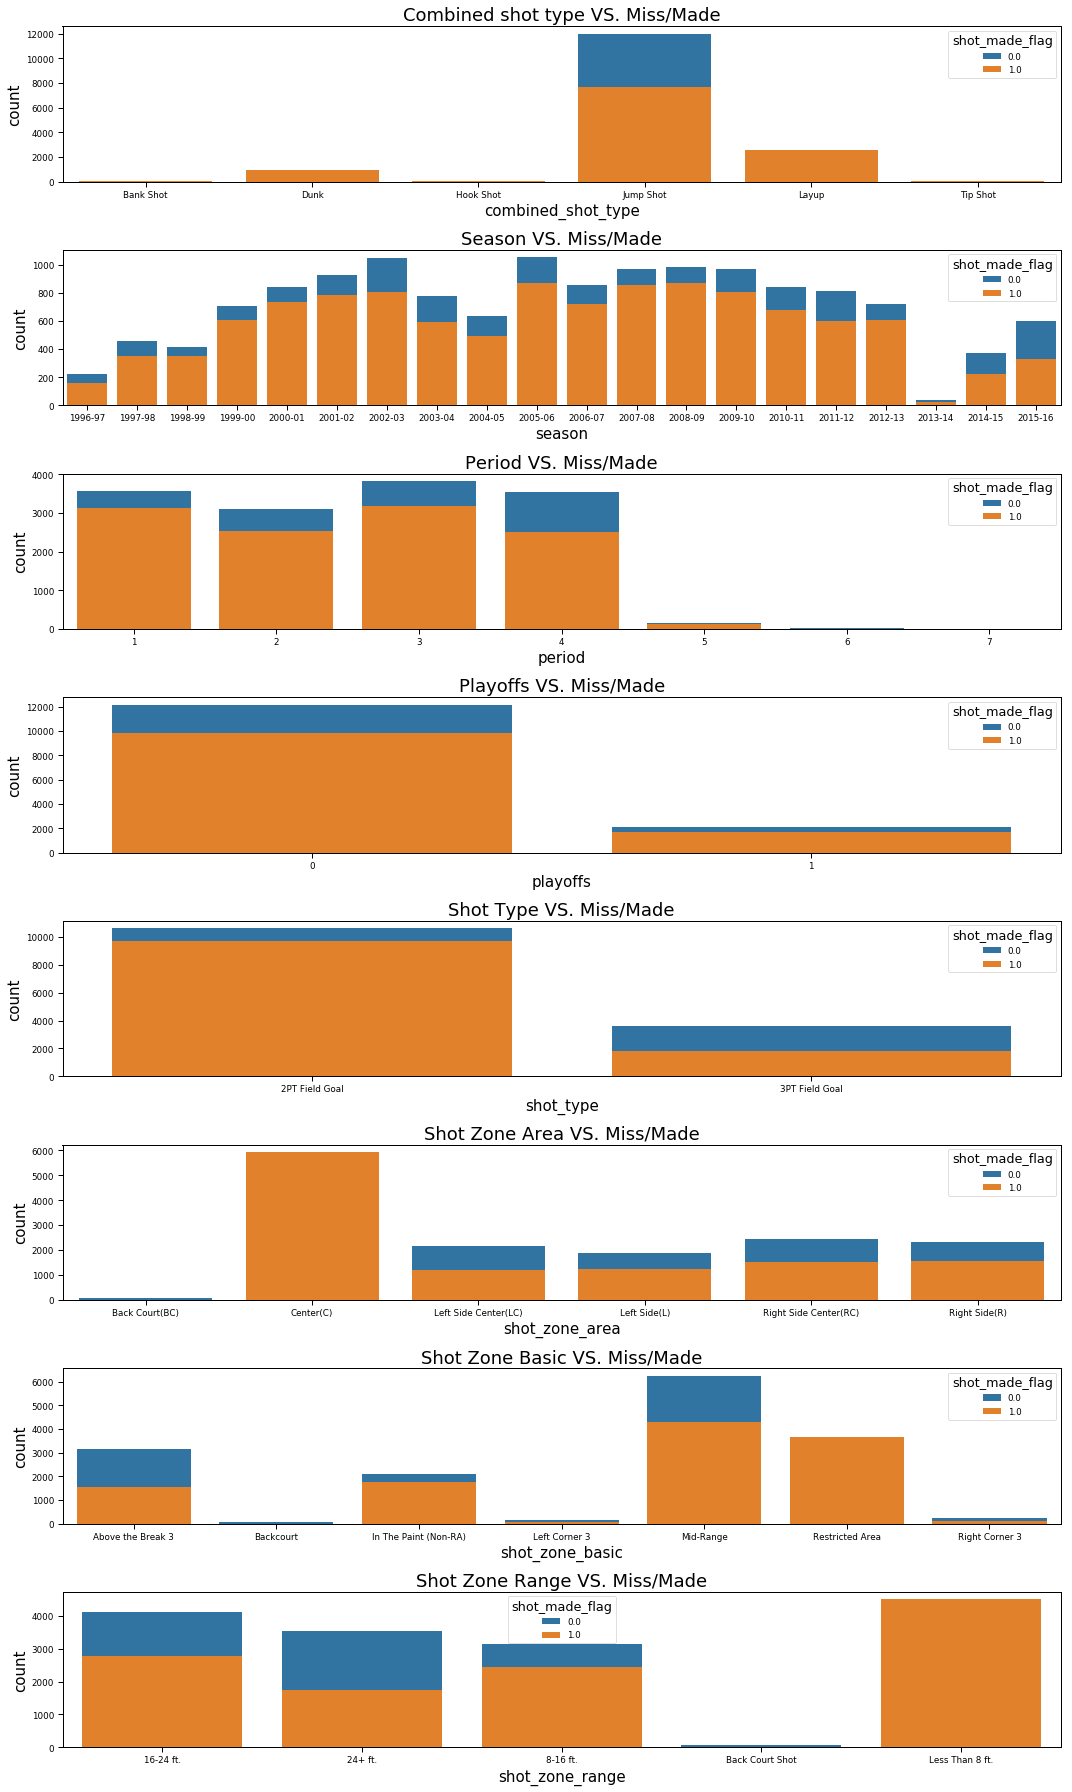

In [27]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data, ax=axarr[0], dodge=False)
sns.countplot(x="season", hue="shot_made_flag", data=data, ax=axarr[1], dodge=False)
sns.countplot(x="period", hue="shot_made_flag", data=data, ax=axarr[2], dodge=False)
sns.countplot(x="playoffs", hue="shot_made_flag", data=data, ax=axarr[3], dodge=False)
sns.countplot(x="shot_type", hue="shot_made_flag", data=data, ax=axarr[4], dodge=False)
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data, ax=axarr[5], dodge=False)
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data, ax=axarr[6], dodge=False)
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data, ax=axarr[7], dodge=False)

axarr[0].set_title('Combined shot type VS. Miss/Made')
axarr[1].set_title('Season VS. Miss/Made')
axarr[2].set_title('Period VS. Miss/Made')
axarr[3].set_title('Playoffs VS. Miss/Made')
axarr[4].set_title('Shot Type VS. Miss/Made')
axarr[5].set_title('Shot Zone Area VS. Miss/Made')
axarr[6].set_title('Shot Zone Basic VS. Miss/Made')
axarr[7].set_title('Shot Zone Range VS. Miss/Made')

plt.tight_layout()
plt.show()

## 4. Data Cleaning

In [28]:
data_cl = data.copy() # for modeling
target = data_cl.shot_made_flag.copy()

### 4.1 Feature Dropping

In [29]:
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent id
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent id
data_cl.drop('shot_made_flag', axis=1, inplace=True) # That's the target

### 4.2 Feature Engineering

In [30]:
# Remaining time
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5 # for game winners

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('category')

data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])

data_cl['game_year'] = data_cl['game_date'].dt.year.astype('category')
data_cl['game_month'] = data_cl['game_date'].dt.month.astype('category')

data_cl.drop('game_date', axis=1, inplace=True)

# Loc_x, and loc_y binning
data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

data_cl['shot_distance'] = (data_cl['shot_distance'] - np.min(data_cl['shot_distance'])) / (np.max(data_cl['shot_distance']) - np.min(data_cl['shot_distance']))

# Replace 40 least common action types with value 'Others'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:40]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Others'

In [31]:
data_cl.describe(include = ['number'])

,shot_distance
count,30697.000000
mean,0.170094
std,0.118661
min,0.000000
25%,0.063291
50%,0.189873
75%,0.265823
max,1.000000


In [32]:
data_cl.describe(include = ['object', 'category'])

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,home_play,game_year,game_month
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,18,6,25,25,7,2,20,2,6,7,5,33,2,21,9
top,Jump Shot,Jump Shot,"(-10.96, 8.96]","(-10.6, 22.8]",3,0,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,SAS,False,2009,3
freq,18880,23485,7390,9781,8296,26198,2318,24271,13455,12625,9398,1978,15741,2357,5132


In [33]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'loc_x', 'loc_y', 'period', 
    'playoffs', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 
    'shot_zone_range', 'opponent', 'home_play', 'game_year', 'game_month'
]

for col in categorial_cols:
    dummies = pd.get_dummies(data_cl[col])
    dummies = dummies.add_prefix("{}#".format(col))
    data_cl.drop(col, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [34]:
data_cl.head()

,shot_distance,last_5_sec_in_period,action_type#Alley Oop Dunk Shot,action_type#Driving Dunk Shot,action_type#Driving Layup Shot,action_type#Dunk Shot,action_type#Fadeaway Jump Shot,action_type#Floating Jump shot,action_type#Jump Bank Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Others,action_type#Pullup Jump shot,action_type#Reverse Layup Shot,action_type#Running Jump Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248.0]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123.0]","loc_y#(123.0, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2, 256.6]","loc_y#(256.6, 290.0]","loc_y#(290.0, 323.4]","loc_y#(323.4, 356.8]","loc_y#(356.8, 390.2]","loc_y#(390.2, 423.6]","loc_y#(423.6, 457.0]","loc_y#(457.0, 490.4]","loc_y#(490.4, 523.8]","loc_y#(523.8, 557.2]","loc_y#(557.2, 590.6]","loc_y#(590.6, 624.0]","loc_y#(624.0, 657.4]","loc_y#(657.4, 690.8]","loc_y#(690.8, 724.2]","loc_y#(724.2, 757.6]","loc_y#(757.6, 791.0]",period#1,period#2,period#3,period#4,period#5,period#6,period#7,playoffs#0,playoffs#1,season#1996-97,season#1997-98,season#1998-99,season#1999-00,season#2000-01,season#2001-02,season#2002-03,season#2003-04,season#2004-05,season#2005-06,season#2006-07,season#2007-08,season#2008-09,season#2009-10,season#2010-11,season#2011-12,season#2012-13,season#2013-14,season#2014-15,season#2015-16,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,home_play#False,home_play#True,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12
shot_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.227848,False,0,0,0,0,0,0,0,1

In [35]:
data_cl.shape

(30697, 190)

### 4.3 Feature Selection

In [36]:
unknown_mask = data['shot_made_flag'].notnull()

In [37]:
# Separate dataset for testing at last
data_submit = data_cl[~unknown_mask]

# Separate dataset for training & validation
X = data_cl[unknown_mask]
y = target[unknown_mask]

#### Variance Filtering

In [38]:
threshold = 0.8 # make the length of features about 20, which is the top 10% of orginal features
vt = VarianceThreshold().fit(X)

feat_var_threshold = X.columns[vt.variances_ > threshold * (1 - threshold)]
feat_var_threshold

Index(['action_type#Jump Shot', 'combined_shot_type#Jump Shot',
       'loc_x#(-10.96, 8.96]', 'loc_y#(-10.6, 22.8]', 'period#1', 'period#2',
       'period#3', 'period#4', 'shot_type#2PT Field Goal',
       'shot_type#3PT Field Goal', 'shot_zone_area#Center(C)',
       'shot_zone_basic#Mid-Range', 'shot_zone_basic#Restricted Area',
       'shot_zone_range#16-24 ft.', 'shot_zone_range#24+ ft.',
       'shot_zone_range#8-16 ft.', 'shot_zone_range#Less Than 8 ft.',
       'home_play#False', 'home_play#True'],
      dtype='object')

In [39]:
len(feat_var_threshold)

19

#### Random Forest Importance Ranking

In [40]:
model = RandomForestClassifier()
model.fit(X, y.tolist())

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index(['shot_distance', 'action_type#Jump Shot', 'period#3', 'period#2',
       'home_play#False', 'home_play#True', 'period#1',
       'action_type#Layup Shot', 'period#4', 'game_month#3', 'game_month#2',
       'game_month#4', 'game_month#12', 'game_month#1', 'game_month#11',
       'opponent#SAS', 'loc_y#(-10.6, 22.8]', 'action_type#Driving Layup Shot',
       'loc_x#(-10.96, 8.96]', 'opponent#HOU'],
      dtype='object')

#### SelectKBest with Chi-square

In [41]:
X_minmax = MinMaxScaler().fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y.tolist())
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

array(['combined_shot_type#Dunk', 'action_type#Jump Shot',
       'shot_zone_basic#Restricted Area', 'loc_x#(-10.96, 8.96]',
       'action_type#Driving Layup Shot',
       'shot_zone_range#Less Than 8 ft.', 'loc_y#(-10.6, 22.8]',
       'action_type#Slam Dunk Shot', 'action_type#Others',
       'shot_type#3PT Field Goal', 'action_type#Driving Dunk Shot',
       'shot_zone_area#Center(C)', 'action_type#Running Jump Shot',
       'shot_zone_range#24+ ft.', 'shot_zone_basic#Above the Break 3',
       'combined_shot_type#Layup', 'combined_shot_type#Jump Shot',
       'last_5_sec_in_period', 'action_type#Jump Bank Shot',
       'action_type#Pullup Jump shot'], dtype=object)

#### Recursive Feature Elimination

In [42]:
rfe = RFE(LogisticRegression(), 20)
rfe.fit(X, y)

feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe_20 = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe_20

array(['last_5_sec_in_period', 'action_type#Alley Oop Dunk Shot',
       'action_type#Driving Dunk Shot', 'action_type#Dunk Shot',
       'action_type#Jump Bank Shot', 'action_type#Jump Shot',
       'action_type#Layup Shot', 'action_type#Others',
       'action_type#Running Jump Shot', 'action_type#Slam Dunk Shot',
       'combined_shot_type#Dunk', 'combined_shot_type#Hook Shot',
       'combined_shot_type#Tip Shot', 'loc_y#(290.0, 323.4]',
       'loc_y#(356.8, 390.2]', 'loc_y#(390.2, 423.6]',
       'loc_y#(423.6, 457.0]', 'shot_zone_area#Back Court(BC)',
       'shot_zone_basic#Backcourt', 'shot_zone_range#Back Court Shot'],
      dtype=object)

#### To Sum Up

In [43]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        feat_rfe_20
    ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-action_type#Alley Oop Dunk Shot
	-action_type#Driving Dunk Shot
	-action_type#Driving Layup Shot
	-action_type#Dunk Shot
	-action_type#Jump Bank Shot
	-action_type#Jump Shot
	-action_type#Layup Shot
	-action_type#Others
	-action_type#Pullup Jump shot
	-action_type#Running Jump Shot
	-action_type#Slam Dunk Shot
	-combined_shot_type#Dunk
	-combined_shot_type#Hook Shot
	-combined_shot_type#Jump Shot
	-combined_shot_type#Layup
	-combined_shot_type#Tip Shot
	-game_month#1
	-game_month#11
	-game_month#12
	-game_month#2
	-game_month#3
	-game_month#4
	-home_play#False
	-home_play#True
	-last_5_sec_in_period
	-loc_x#(-10.96, 8.96]
	-loc_y#(-10.6, 22.8]
	-loc_y#(290.0, 323.4]
	-loc_y#(356.8, 390.2]
	-loc_y#(390.2, 423.6]
	-loc_y#(423.6, 457.0]
	-opponent#HOU
	-opponent#SAS
	-period#1
	-period#2
	-period#3
	-period#4
	-shot_distance
	-shot_type#2PT Field Goal
	-shot_type#3PT Field Goal
	-shot_zone_area#Back Court(BC)
	-shot_zone_area#Center(C)
	-shot_zone_basic#Above the Br

In [44]:
data_cl = data_cl.ix[:, features]
data_submit = data_submit.ix[:, features]
X = X.ix[:, features]

print('Clean dataset shape: {}'.format(data_cl.shape))
print('Test dataset shape: {}'.format(data_submit.shape))
print('Train/Validation features shape: {}'.format(X.shape))
print('Train/Validation target shape: {}'. format(y.shape))

Clean dataset shape: (30697, 51)
Test dataset shape: (5000, 51)
Train/Validation features shape: (25697, 51)
Train/Validation target shape: (25697,)


## 5. Modeling

### 5.1 Preparation 

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y.tolist(), test_size = 0.3, random_state = 42)
print('Training set features shape: {}'.format(X_train.shape))
print('Training set target shape: {}'. format(pd.Series(y_train).shape))

Training set features shape: (17987, 51)
Training set target shape: (17987,)


In [46]:
seed = 42
processors = -1 # use all the CPUs
scoring = 'roc_auc' # auc for the evaluation
kfold = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed) # repeated k-fold

### 5.2 Single Modeling

In [47]:
# Prepare some basic models
models = [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()) 
    #,('SVC', SVC(probability=True) # time consuming
]

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (0.700) +/- (0.012)
LDA: (0.700) +/- (0.012)
KNN: (0.635) +/- (0.012)
CART: (0.606) +/- (0.011)
NB: (0.656) +/- (0.035)


In [48]:
cart = DecisionTreeClassifier() # base learner
num_trees = 100

model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)

results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=processors)
print("Bagging Trees: ({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

Bagging Trees: (0.651) +/- (0.011)


In [49]:
num_trees = 100
num_features = 10

model = RandomForestClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=processors)
print("Random Forest: ({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

Random Forest: (0.654) +/- (0.012)


In [50]:
num_trees = 100
num_features = 10

model = ExtraTreesClassifier(n_estimators=num_trees, max_features=num_features)

results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=processors)
print("Extra Trees: ({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

Extra Trees: (0.634) +/- (0.012)


In [51]:
model = AdaBoostClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=processors)
print("AdaBoost: ({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

AdaBoost: (0.701) +/- (0.011)


In [52]:
model = GradientBoostingClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=processors)
print("GBDT: ({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

GBDT: (0.703) +/- (0.012)


### 5.3 Grid / Random Search Cross Validation

In [53]:
lr_grid = GridSearchCV(
    estimator = LogisticRegression(random_state=seed),
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [50, 100, 200] # 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lr_grid.fit(X_train, y_train)

print("Logistic:")
print("="*30)
print(lr_grid.best_score_)
print(lr_grid.best_params_)

Logistic:
0.700080345517174
{'C': 200, 'penalty': 'l2'}


In [54]:
lda_grid = GridSearchCV(
    estimator = LinearDiscriminantAnalysis(),
    param_grid = {
        'solver': ['svd', 'lsqr'], #'shrinkage': [0, 0.25, 0.5, 0.75, 1]
        'n_components': [None, 2, 5]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lda_grid.fit(X_train, y_train)

print("Linear Discriminant Analysis:")
print("="*30)
print(lda_grid.best_score_)
print(lda_grid.best_params_)

Linear Discriminant Analysis:
0.6999403929634942
{'n_components': None, 'solver': 'svd'}


In [55]:
bag_grid = RandomizedSearchCV(
    estimator = BaggingClassifier(base_estimator=cart, warm_start=True, random_state=seed),
    param_distributions = {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.1, 0.3, 0.5],
        'max_features': [0.5, 0.7, 0.9]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

bag_grid.fit(X_train, y_train)

print("Bagging Trees:")
print("="*30)
print(bag_grid.best_score_)
print(bag_grid.best_params_)

Bagging Trees:
0.6928390181765188
{'n_estimators': 200, 'max_samples': 0.1, 'max_features': 0.5}


In [56]:
rf_grid = RandomizedSearchCV(
    estimator = RandomForestClassifier(warm_start=True, random_state=seed),
    param_distributions = {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [8, 10, 12],
        'max_features': ['sqrt', 'log2']
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X_train, y_train)

print("Random Forest:")
print("="*30)
print(rf_grid.best_score_)
print(rf_grid.best_params_)

Random Forest:
0.7025814642964865
{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


In [57]:
ada_grid = RandomizedSearchCV(
    estimator = AdaBoostClassifier(random_state=seed),
    param_distributions = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

ada_grid.fit(X_train, y_train)

print("Adaboost:")
print("="*30)
print(ada_grid.best_score_)
print(ada_grid.best_params_)

Adaboost:
0.7009646560375772
{'n_estimators': 200, 'learning_rate': 1, 'algorithm': 'SAMME.R'}


In [58]:
gbm_grid = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(warm_start=True, random_state=seed),
    param_distributions = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5],
        'max_features': [0.1, 0.3, 0.5],
        'learning_rate': [0.1, 0.2, 0.5]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

gbm_grid.fit(X_train, y_train)

print("Gradiant Boosting Machine:")
print("="*30)
print(gbm_grid.best_score_)
print(gbm_grid.best_params_)

Gradiant Boosting Machine:
0.7049843179517015
{'n_estimators': 50, 'max_features': 0.3, 'max_depth': 4, 'learning_rate': 0.2}


In [59]:
start = time.time()

xg_cl = xgb.XGBClassifier(objective = 'binary:logistic', seed = seed)

# to use XGBoost, feature name transformation is needed
Dtrain = X_train.copy()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
Dtrain.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

xgb_grid = RandomizedSearchCV(
    estimator = xg_cl, 
    param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1], 
    'n_estimators': [50, 100, 200],
    'subsample': [0.3, 0.5, 0.7]
}, 
    n_iter = 10, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors,
    verbose = False) 

xgb_grid.fit(Dtrain, y_train)

print("Best parameters found: ", xgb_grid.best_params_)
print("Highest AUC found: ", np.abs(xgb_grid.best_score_))

print("="*30)    
print("Time used: ", round(time.time() - start, 3), "s")

Best parameters found:  {'subsample': 0.7, 'n_estimators': 200, 'learning_rate': 0.05}
Highest AUC found:  0.7051456397087971
Time used:  1257.303 s


In [60]:
model_x = xgb.XGBClassifier(objective='binary:logistic', subsample=0.7, n_estimators=200, learning_rate=0.05 , seed=seed)

# to use XGBoost, feature name transformation is needed
Dtest = X_test.copy()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
Dtest.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

model_x.fit(Dtrain, y_train)
preds_test = model_x.predict(Dtest)
accuracy = float(np.sum(preds_test == y_test)) / pd.Series(y_test).shape[0]
print("Accuracy: ", round(accuracy, 3))

Accuracy:  0.676


### 5.4 Stacking & Voting

#### StackingClassifier

In [61]:
start = time.time()

clf1 = LogisticRegression(penalty='l2', C=200)
clf2 = LinearDiscriminantAnalysis(solver = 'lsqr', n_components = None)
clf3 = BaggingClassifier(base_estimator=cart, max_features=0.7, max_samples=0.1, n_estimators=200, warm_start=True, random_state=seed)
clf4 = RandomForestClassifier(max_depth=8, n_estimators=50, max_features='sqrt', criterion='gini', warm_start=True, random_state=seed)
clf5 = AdaBoostClassifier(n_estimators=100, learning_rate=1, algorithm='SAMME.R')
clf6 = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.2, max_features=0.1, warm_start=True, random_state=seed)
clf7 = xgb.XGBClassifier(objective='binary:logistic', subsample=0.5, n_estimators=200, learning_rate=0.05 , seed=seed)

lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6, clf7], 
                          #use_probas=True, #average_probas=False,
                          meta_classifier=lr)

print('10-time 10-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, sclf], 
                      ['LR', 
                       'LDA', 
                       'Bagging Trees',
                       'Random Forest',
                       'Adaboost',
                       'GBDT',
                       'XGBoost',
                       'Stacking']):

    scores = cross_val_score(clf, Dtrain, y_train, cv=kfold, scoring=scoring)
    print("AUC: %0.3f (+/- %0.3f) [%s]" 
          % (scores.mean(), scores.std(), label))

print("="*30)    
print("Time used: ", round(time.time() - start, 3), "s")

10-time 10-fold cross validation:

AUC: 0.700 (+/- 0.012) [LR]
AUC: 0.700 (+/- 0.012) [LDA]
AUC: 0.694 (+/- 0.013) [Bagging Trees]
AUC: 0.701 (+/- 0.013) [Random Forest]
AUC: 0.701 (+/- 0.011) [Adaboost]
AUC: 0.704 (+/- 0.012) [GBDT]
AUC: 0.705 (+/- 0.012) [XGBoost]
AUC: 0.662 (+/- 0.011) [Stacking]
Time used:  2893.794 s


In [62]:
model_s = sclf

# to use XGBoost, feature name transformation is needed
Dtest = X_test.copy()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
Dtest.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

model_s.fit(Dtrain, y_train)
preds_test = model_s.predict(Dtest)
accuracy = float(np.sum(preds_test == y_test)) / pd.Series(y_test).shape[0]
print("Accuracy: ", round(accuracy, 3))

Accuracy:  0.671


#### VotingClassifier

In [63]:
start = time.time()

# Create sub models
estimators = [
    ('lr',clf1),
    ('lda',clf2),
    ('bag',clf3),
    ('rf',clf4),
    ('ada',clf5),
    ('gbm',clf6),
    ('xgb',clf7)
]

# Create the ensemble model
ensemble = VotingClassifier(estimators, voting = 'soft') #, weights = [1,1,1,1,1,1,4]
results = cross_val_score(ensemble, Dtrain, y_train, cv = kfold, scoring = scoring, n_jobs = processors)

print("Ensemble:")
print("="*30)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

print("Time used: ", round(time.time() - start, 3), "s")

Ensemble:
(0.705) +/- (0.012)
Time used:  580.497 s


In [64]:
model = ensemble

# to use XGBoost, feature name transformation is needed
Dtest = X_test.copy()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
Dtest.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

model.fit(Dtrain, y_train)
preds_test = model.predict(Dtest)
accuracy = float(np.sum(preds_test == y_test)) / pd.Series(y_test).shape[0]
print("Accuracy: ", round(accuracy, 3))

Accuracy:  0.677


#### Stacking with Grid Search

In [65]:
start = time.time()

params = {'meta-logisticregression__penalty': ['l1', 'l2'], 
          'meta-logisticregression__C': [0.1, 1, 10]}

grid = GridSearchCV(estimator=sclf,
                    param_grid=params,
                    cv=kfold,
                    scoring=scoring,
                    refit=True)

grid.fit(Dtrain, y_train)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']): 
    print("%0.3f +/- %0.3f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))
    
print('Best parameters: %s' % grid.best_params_)
print('Best AUC: %.3f' % grid.best_score_)

print("Time used: ", round(time.time() - start, 3), "s")

0.664 +/- 0.005 {'meta-logisticregression__C': 0.1, 'meta-logisticregression__penalty': 'l1'}
0.663 +/- 0.005 {'meta-logisticregression__C': 0.1, 'meta-logisticregression__penalty': 'l2'}
0.662 +/- 0.006 {'meta-logisticregression__C': 1, 'meta-logisticregression__penalty': 'l1'}
0.662 +/- 0.005 {'meta-logisticregression__C': 1, 'meta-logisticregression__penalty': 'l2'}
0.662 +/- 0.006 {'meta-logisticregression__C': 10, 'meta-logisticregression__penalty': 'l1'}
0.662 +/- 0.006 {'meta-logisticregression__C': 10, 'meta-logisticregression__penalty': 'l2'}
Best parameters: {'meta-logisticregression__C': 0.1, 'meta-logisticregression__penalty': 'l1'}
Best AUC: 0.664
Time used:  12989.338 s


In [67]:
model_g = grid

# to use XGBoost, feature name transformation is needed
Dtest = X_test.copy()
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
Dtest.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

model_g.fit(Dtrain, y_train)
preds_test = model_g.predict(Dtest)
accuracy = float(np.sum(preds_test == y_test)) / pd.Series(y_test).shape[0]
print("Accuracy: ", round(accuracy, 3))